# 学習過程の可視化とパラメーターチューニング – MNIST データ

## import

In [1]:
from keras.datasets import mnist
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.optimizers import SGD
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## MNISTデータの取得

In [2]:
# x1 : 入力データ
# t1 : 正解データ（ターゲット）
# ex1 : 評価用入力データ
# et1 : 評価用正解データ（ターゲット）
(x1, t1), (ex1, et1) = mnist.load_data()

print(x1.shape,t1.shape)

# 60000, 28^2 の二次元配列の入力データ x2 と評価用入力 ex2 に変換します。
x2 = x1.reshape(len(x1), x1[0].size)
ex2 = ex1.reshape(len(ex1), ex1[0].size)
print(x2.shape, ex2.shape)

# 訓練用ターゲット t1 と評価用ターゲット et1 の両方をスカラー値からベクトル t2, et2 に to_categorical で変換します。
from keras.utils import np_utils
t2 = np_utils.to_categorical(t1)
et2 = np_utils.to_categorical(et1)
 
# 訓練用と評価用から1個づつ表示
print(t2[0])
print(et2[0])

(60000, 28, 28) (60000,)
(60000, 784) (10000, 784)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [3]:
def training(x2, t2, ex2, et2, model, epochs, batch_size):
    return model.fit(x2, t2, epochs=epochs, batch_size=batch_size, validation_data=(ex2, et2)) 


def plot_training(result, epochs):
    plt.plot(range(1, epochs+1), result.history['acc'], label="training")
    plt.plot(range(1, epochs+1), result.history['val_acc'], label="validation")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()    

## network

In [8]:
n_in = x2[0].size
n_out = t2[0].size
hidden_layers = 10 #2
hidden_units = 30
# activation_function='sigmoid'
activation_function='relu' # 活性化関数を ReLU にする
learning_rate = 0.01

# モデル定義
np.random.seed(0) # 乱数を固定値で初期化し再現性を持たせる
model = Sequential()
# 入力層
model.add(Dense(hidden_units, input_dim=n_in)) # 入力層から出力するユニット数は隠し層のユニット数と同数に
model.add(Activation(activation_function))
# 隠し層
for _ in range(hidden_layers):
    model.add(Dense(hidden_units))
    model.add(Activation(activation_function))   
# 出力層
model.add(Dense(n_out))
model.add(Activation('softmax'))
# モデル生成
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=learning_rate),metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 30)                23550     
_________________________________________________________________
activation_13 (Activation)   (None, 30)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 30)                930       
_________________________________________________________________
activation_14 (Activation)   (None, 30)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 30)                930       
_________________________________________________________________
activation_15 (Activation)   (None, 30)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 30)                930       
__________

In [5]:
epochs = 5
batch_size = 50

In [8]:
result = training(x2, t2, ex2, et2, model, epochs, batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 72s 1ms/step - loss: 1.5622 - acc: 0.5317 - val_loss: 0.9797 - val_acc: 0.6942
Epoch 2/5
60000/60000 [==============================] - 52s 860us/step - loss: 1.0545 - acc: 0.6475 - val_loss: 1.1423 - val_acc: 0.6015
Epoch 3/5
60000/60000 [==============================] - 24s 399us/step - loss: 1.0414 - acc: 0.6463 - val_loss: 0.9650 - val_acc: 0.7007
Epoch 4/5
60000/60000 [==============================] - 21s 344us/step - loss: 1.0129 - acc: 0.6429 - val_loss: 0.9932 - val_acc: 0.6615
Epoch 5/5
60000/60000 [==============================] - 28s 464us/step - loss: 0.9407 - acc: 0.6733 - val_loss: 0.8548 - val_acc: 0.6925


In [23]:
result = model.predict_classes(ex2, batch_size=batch_size)
print()
print("**** RESULT ****")
_, et3 = np.where(et2 > 0) # to_categorical の逆変換
print(result == et3)

sum(result == et3) / 10000


**** RESULT ****
[ True  True  True ... False False  True]


0.6904

model の metrics_names でどのような評価結果が入っているのかリスト出来ますので確認してみます。

In [21]:
model.metrics_names

['loss', 'acc']

## 学習を評価する指標

ここまでは実際に分類させた結果を集計して学習の評価を行ってきました。  
機械学習の評価の指標には 正解率(accuracy), 適合率(precision), 再現率(recall), が代表的です。

これらの指標の計算には、まず結果を4つのパターンに分類します。

- 正解が 1 のときに正しく 1 と予測 **真陽性(true positive)**
- 正解が 1 のときに誤って 0 と予測 **偽陰性(false negative)**
- 正解が 0 のときに誤って 1 と予測 **偽陽性(false positive)**
- 正解が 0 のときに正しく 0 と予測 **真陰性(true negative)**

機械学習の正しさの指標はこれらの分類を使って計上します。

例として「ある病気の場合に**真**になる検査」の場合の分類を表にします。

| <i></i>  | 検査で陽性 | 検査で陰性 |
|----------|------------|------------|
| 実は病気 | 真陽性     | 偽陰性     |
| 実は健康 | 偽陽性     | 真陰性     |

### 適合率(precision)

適合率は 真陽性 / (真陽性 + 偽陽性) で求められます。

前述の表の例で解釈すると「検査で陽性の場合に本当に病気だった確率」と言えます。

検査で陽性にもかからず病気ではないケースを最小化するのを目的とするケースで、病気であると予測した結果がいかに正確であるかに焦点をあてた指標です。

### 再現率(recall)

計算式は 真陽性 / (真陽性 + 偽陰性) になります。

表では「実際に病気だった人が検査で正しく陽性になる確率」と言えます。

病気にも関わらず検査で発見されない（陰性になる）ケースを最小化するのを目的としたケースで、実際に真となる状態（病気であること）を漏れずに網羅出来ているかどうかに焦点をあてた指標になります。

### 正解率 (accuracy)

(真陽性 + 真陰性) / (真陽性 + 偽陰性 + 偽陽性 + 真陰性) が計算式で、全てのパターンを考慮して「正しかった割合」を計算します。

病気と検査の関係の場合、敏感に陽性になるような検査をつくれば再現率は上がりますが、適合率や正解率は下がります。 一方、群衆の中から特定の人を見つけ出すなど、 予測や分類の結果の正しさが何より重視されるケースでは、再現率や正解率より適合率が重視されます。

本記事での指標としては accuracy を使いますが、全てのパターンで正解率 (accuracy) を追求するより好ましい指標のケースもあるという点は覚えておきましょう。

## Keras 内で評価を測定する
モデル作成時にどういう指標を評価するかを metrics パラメータで設定します。

デフォルトで損失関数の評価値 ‘loss’ は設定されていますので今回は model.compile 文で正解率 ‘acc’ を追加し model.fit を実行します。

[metrics一覧](https://keras.io/ja/metrics/)



In [ ]:
# モデル生成
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=learning_rate), metrics=['acc'])

ここまで予想や分類といった出力を得るには model.predit_classes を使いましたが、評価データ ex2 と評価ターゲット et2 を使って評価だけを実行する model.evaluate を代わりに実行します。実行すると、前述どおりloss と accuracy の結果を返してくれます。

評価データ ex2 と評価ターゲット et2 を使って評価だけを実行する model.evaluate を代わりに実行します。実行すると、前述どおりloss と accuracy の結果を返してくれます。

In [22]:
'''
結果評価
'''
result = model.evaluate(ex2, et2)
print("**** RESULT ****")
print("Accuracy = ", result[1]) # 2つ目が acc

10000/10000 [==============================] - 4s 443us/step
**** RESULT ****
Accuracy =  0.6904


## 学習過程の可視化
5 回訓練を繰り返した後評価データで 65% に到達しましたが、その途中の経過を数値ではなくグラフで見てみましょう。学習させる model.fit のパラメーターに validation_data という配列で評価データとターゲットを与えておくと、model.fit の返り値の history オブジェクトに epoch 毎の訓練データでの評価と、validation_data での評価とそれぞれの結果を記録してくれます。

In [27]:
result

array([7, 2, 1, ..., 9, 8, 6], dtype=int64)

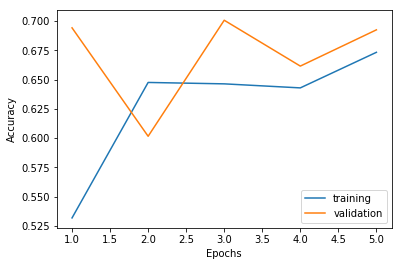

In [9]:
plot_training(result,epochs)

## チューニング

### 学習率
結果をグラフで見ると訓練データの正確性が3回目以降は低下、評価データの方も向上する傾向が見えない状況となっています。

このようになるケースはいろいろありますが、まず考えられるのは訓練データに対して学習しすぎてしまうという 過学習 が考えられます。  
また、このケースでは1回目の epoch から評価データで 68% の正確性を出していることから 学習速度が早すぎる 可能性があります。

まずは 0.1 に設定してあった learning_rate を 0.01 に落としてみましょう。

In [10]:
learning_rate = 0.01 # 学習率を 0.01 に下げる

In [11]:
# モデル生成
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=learning_rate), metrics=['acc'])
result = training(x2, t2, ex2, et2, model, epochs, batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 27s 456us/step - loss: 0.8441 - acc: 0.7169 - val_loss: 0.8188 - val_acc: 0.7200
Epoch 2/5
60000/60000 [==============================] - 24s 396us/step - loss: 0.8193 - acc: 0.7266 - val_loss: 0.7882 - val_acc: 0.7312
Epoch 3/5
60000/60000 [==============================] - 25s 413us/step - loss: 0.7917 - acc: 0.7372 - val_loss: 0.7807 - val_acc: 0.7392
Epoch 4/5
60000/60000 [==============================] - 21s 345us/step - loss: 0.7764 - acc: 0.7489 - val_loss: 0.7680 - val_acc: 0.7494
Epoch 5/5
60000/60000 [==============================] - 21s 345us/step - loss: 0.7519 - acc: 0.7626 - val_loss: 0.7323 - val_acc: 0.7721


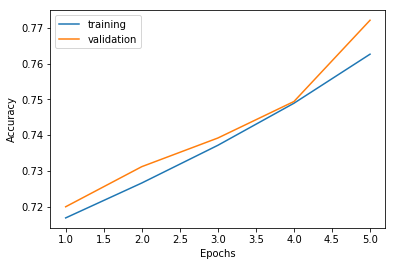

In [12]:
plot_training(result,epochs)

Accuracy が安定して上昇していく結果になりました。  
またグラフを見ますとまだまだ向上し続ける途中の形に読み取れますので、単純に epochs=10 にしてみます。

In [13]:
epochs = 10
result = training(x2, t2, ex2, et2, model, epochs, batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 58s 963us/step - loss: 0.7372 - acc: 0.7694 - val_loss: 0.7308 - val_acc: 0.7655
Epoch 2/10
60000/60000 [==============================] - 49s 824us/step - loss: 0.7206 - acc: 0.7732 - val_loss: 0.6961 - val_acc: 0.7908
Epoch 3/10
60000/60000 [==============================] - 50s 825us/step - loss: 0.6998 - acc: 0.7912 - val_loss: 0.6761 - val_acc: 0.7950
Epoch 4/10
60000/60000 [==============================] - 53s 883us/step - loss: 0.6816 - acc: 0.7961 - val_loss: 0.6748 - val_acc: 0.7929
Epoch 5/10
60000/60000 [==============================] - 64s 1ms/step - loss: 0.6787 - acc: 0.7908 - val_loss: 0.6620 - val_acc: 0.7966
Epoch 6/10
60000/60000 [==============================] - 16s 262us/step - loss: 0.6641 - acc: 0.7975 - val_loss: 0.6464 - val_acc: 0.8089
Epoch 7/10
60000/60000 [==============================] - 15s 255us/step - loss: 0.6535 - acc: 0.8039 - val_loss: 0.64

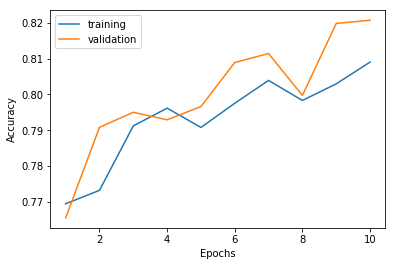

In [14]:
plot_training(result,epochs)

Accuracy は 85%, epoch の 10 回目でグラフも頂上に達してきたように見えます。 このまま epoch を増やしていっても向上するのは僅かですので、別のアプローチでチューニングしてみます。

### 中間層追加
次に中間層を追加し 10 にしてみます。 hidden_layers=10 に設定を変更し実行します。

In [6]:
epochs = 10
result = training(x2, t2, ex2, et2, model, epochs, batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 38s 637us/step - loss: 2.3079 - acc: 0.1101 - val_loss: 2.3014 - val_acc: 0.1135
Epoch 2/10
60000/60000 [==============================] - 31s 523us/step - loss: 2.3016 - acc: 0.1113 - val_loss: 2.3012 - val_acc: 0.1135
Epoch 3/10
60000/60000 [==============================] - 29s 484us/step - loss: 2.3017 - acc: 0.1117 - val_loss: 2.3011 - val_acc: 0.1135
Epoch 4/10
60000/60000 [==============================] - 29s 490us/step - loss: 2.3017 - acc: 0.1122 - val_loss: 2.3015 - val_acc: 0.1135
Epoch 5/10
60000/60000 [==============================] - 28s 470us/step - loss: 2.3016 - acc: 0.1121 - val_loss: 2.3014 - val_acc: 0.1135
Epoch 6/10
60000/60000 [==============================] - 47s 777us/step - loss: 2.3017 - acc: 0.1123 - val_loss: 2.3015 - val_acc: 0.1135
Epoch 7/10
60000/60000 [==============================] - 70s 1ms/step - loss: 2.3017 - acc: 0.1120 - val_loss: 2.30

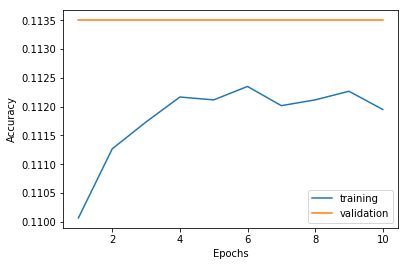

In [7]:
plot_training(result,epochs)

訓練、評価ともまったく学習出来なくなってしまいました。

あらゆる入力値に対して 0 ～ 1 の値を返すシグモイド関数の中間層を重ねたことで、信号の特徴自体が減ってしまう勾配消失問題が発生していた可能性が考えられます。

### 活性化関数

ステップ関数のようにある閾値以上になると発火しつつ、入力値に応じた線形な値で出力する relu 関数という活性化関数があります。

In [9]:
epochs = 10
result = training(x2, t2, ex2, et2, model, epochs, batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 42s 697us/step - loss: 0.6798 - acc: 0.7860 - val_loss: 0.3981 - val_acc: 0.8865
Epoch 2/10
60000/60000 [==============================] - 31s 522us/step - loss: 0.3075 - acc: 0.9130 - val_loss: 0.2496 - val_acc: 0.9293
Epoch 3/10
60000/60000 [==============================] - 28s 463us/step - loss: 0.2473 - acc: 0.9286 - val_loss: 0.2325 - val_acc: 0.9336.2474 -
Epoch 4/10
60000/60000 [==============================] - 30s 492us/step - loss: 0.2129 - acc: 0.9386 - val_loss: 0.2048 - val_acc: 0.9435
Epoch 5/10
60000/60000 [==============================] - 36s 607us/step - loss: 0.1884 - acc: 0.9465 - val_loss: 0.1999 - val_acc: 0.9451
Epoch 6/10
60000/60000 [==============================] - 31s 519us/step - loss: 0.1740 - acc: 0.9499 - val_loss: 0.1657 - val_acc: 0.9511
Epoch 7/10
60000/60000 [==============================] - 31s 516us/step - loss: 0.1663 - acc: 0.9524 - val_l

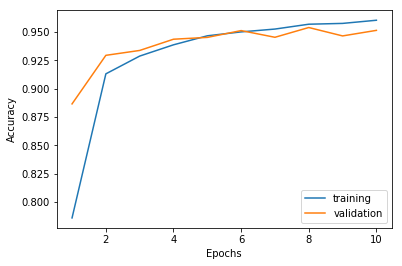

In [10]:
plot_training(result,epochs)

最初は約 85% で頭打ちになっていた学習率をチューニングしたことで約 95% に上げることが出来ました！

## 終わりなきパラメーターチューニング

今回紹介したチューニングは入口部分をほんの少し覗いただけのもので、実際にはニューラルネットの最初の状態をあらかじめ 0 ではなく適したものに初期化しておくことで性能を高める初期化方法のチューニング、入力データの絶対値的な大きさが学習に影響しないようにする データの正規化、局所最適化に陥ることを防止するための ニューロンのドロップアウト など、 様々なチューニングが必要になります。

In [18]:
%%html
<style>table {float:left}</style>